In [1]:
# Import libraries
import sys
sys.path.append('../../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from experiments.temperature import generate_data
from experiments.utils import create_df_from_cached_results, load_share_from_checkpoint, get_n_shapes, get_n_variables
from sklearn.metrics import r2_score
from interpret.glassbox import ExplainableBoostingRegressor
from pysr import PySRRegressor
from interpret import show

In [2]:
# Generate data
df = generate_data(1000, (1,800), (1.0,4.0), (-100,0), seed=0, noise=0.0)

feature_columns = ['energy','mass','initial_temp']
target_column = 'temperature'

X = df[feature_columns].values
y = df[target_column].values

df_test = generate_data(1000, (1,800), (1.0,4.0), (-100,0), seed=1, noise=0.0)
X_test = df_test[feature_columns].values
y_test = df_test[target_column].values

In [3]:
ebm = ExplainableBoostingRegressor(random_state=42)
ebm.fit(X,y)
ebm_global = ebm.explain_global()

In [5]:
r2_score(y_test,ebm.predict(X_test))

0.8754164306867275

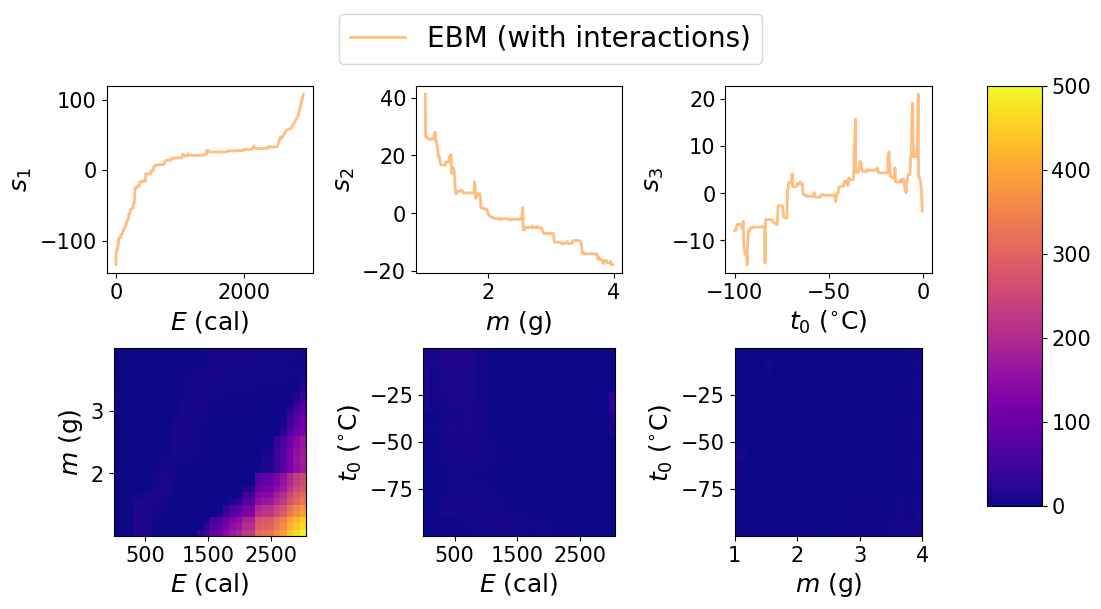

In [4]:
# visualize the shape functions
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']
linewidth = 2.0
alpha = 0.5
markersize = 5.0
label_fontsize = 18
ticks_fontsize = 15

def plot_1(ax,ebm_global):
    shape_data = ebm_global.data(0)
    x_values = shape_data['names']
    y_values = shape_data['scores']
    ax.plot(x_values[:-1],y_values,c=colors[1],linewidth=linewidth, alpha=alpha, label="EBM (no interactions)")
    ax.set_xlabel(r'$E$ (cal)', fontsize=label_fontsize)
    ax.set_ylabel(r"$s_1$", fontsize=label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
def plot_2(ax,ebm_global):
    shape_data = ebm_global.data(1)
    x_values = shape_data['names']
    y_values = shape_data['scores']
    ax.plot(x_values[:-1],y_values,c=colors[1],linewidth=linewidth, alpha=alpha, label="EBM (no interactions)")
    ax.set_xlabel(r'$m$ (g)', fontsize=label_fontsize)
    ax.set_ylabel(r"$s_2$", fontsize=label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
def plot_3(ax,ebm_global, interactions=False):
    shape_data = ebm_global.data(2)
    x_values = shape_data['names']
    y_values = shape_data['scores']
    if interactions:
        ax.plot(x_values[:-1],y_values,c=colors[1],linewidth=linewidth, alpha=alpha, label="EBM (with interactions)")
    else:
        ax.plot(x_values[:-1],y_values,c=colors[1],linewidth=linewidth, alpha=alpha, label="EBM (no interactions)")
    ax.set_xlabel(r'$t_0$ ($^{\circ}$C)', fontsize=label_fontsize)
    ax.set_ylabel(r"$s_3$", fontsize=label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)



def plot_heatmap_1(ax, ebm_global):
    data = ebm_global.data(3)
    im = ax.imshow(data['scores'].T, extent=[data['left_names'][0], data['left_names'][-1],data['right_names'][0], data['right_names'][-1]], origin='lower', aspect=1000, cmap='plasma', vmin=0,vmax=500)
    ax.set_xlabel(r'$E$ (cal)', fontsize=label_fontsize)
    ax.set_ylabel('$m$ (g)', fontsize=label_fontsize)
    ax.set_xticks([500,1500,2500])
    ax.set_xticklabels([500,1500,2500])
    ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
    return im

def plot_heatmap_2(ax, ebm_global):
    data = ebm_global.data(4)
    im = ax.imshow(data['scores'].T, extent=[data['left_names'][0], data['left_names'][-1],data['right_names'][0], data['right_names'][-1]], origin='lower', aspect='30', cmap='plasma', vmin=0,vmax=500)
    ax.set_xlabel(r'$E$ (cal)', fontsize=label_fontsize)
    ax.set_ylabel('$t_0$ ($^{\circ}$C)', fontsize=label_fontsize)
    ax.set_xticks([500,1500,2500])
    ax.set_xticklabels([500,1500,2500])
    ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
    return im

def plot_heatmap_3(ax, ebm_global):
    data = ebm_global.data(5)
    im = ax.imshow(data['scores'].T, extent=[data['left_names'][0], data['left_names'][-1],data['right_names'][0], data['right_names'][-1]], origin='lower', aspect=0.03, cmap='plasma', vmin=0,vmax=500)
    ax.set_xlabel(r'$m$ (g)', fontsize=label_fontsize)
    ax.set_ylabel('$t_0$ ($^{\circ}$C)', fontsize=label_fontsize)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels([1,2,3,4])
    ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
    return im


fig, axs = plt.subplots(2,3,figsize=(11,6))
plot_1(axs[0][0], ebm_global)
plot_2(axs[0][1], ebm_global)
plot_3(axs[0][2], ebm_global, interactions=True)
im = plot_heatmap_1(axs[1][0], ebm_global)
im = plot_heatmap_2(axs[1][1], ebm_global)
im = plot_heatmap_3(axs[1][2], ebm_global)
handles, labels = axs[0][2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=20)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.85, wspace=0.5, hspace=0.4)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
cbar_ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
fig.colorbar(im, cax=cbar_ax)
plt.savefig('figures/Figure_9.pdf')